In [1]:
# Import Library

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle as pk

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_parquet("data/yellow_tripdata_2022-01.parquet")

In [3]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2463931 entries, 0 to 2463930
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [5]:
df.isnull().sum().sort_values(ascending = False)

airport_fee              71503
congestion_surcharge     71503
passenger_count          71503
RatecodeID               71503
store_and_fwd_flag       71503
extra                        0
total_amount                 0
improvement_surcharge        0
tolls_amount                 0
tip_amount                   0
mta_tax                      0
VendorID                     0
fare_amount                  0
tpep_pickup_datetime         0
DOLocationID                 0
PULocationID                 0
trip_distance                0
tpep_dropoff_datetime        0
payment_type                 0
dtype: int64

In [6]:
df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
df["duration"]

0         0 days 00:17:49
1         0 days 00:08:24
2         0 days 00:08:58
3         0 days 00:10:02
4         0 days 00:37:32
                ...      
2463926   0 days 00:05:58
2463927   0 days 00:10:39
2463928   0 days 00:11:00
2463929   0 days 00:12:03
2463930   0 days 00:27:00
Name: duration, Length: 2463931, dtype: timedelta64[ns]

In [7]:
df["duration"] = df["duration"].apply(lambda x : x.total_seconds() / (60))
df["duration"]

0          17.816667
1           8.400000
2           8.966667
3          10.033333
4          37.533333
             ...    
2463926     5.966667
2463927    10.650000
2463928    11.000000
2463929    12.050000
2463930    27.000000
Name: duration, Length: 2463931, dtype: float64

In [8]:
df["duration"].describe(percentiles = [0.01, 0.05, 0.1 ,0.25, 0.5, 0.75, 0.95, 0.98, 0.99])

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
1%       5.833333e-01
5%       2.950000e+00
10%      4.016667e+00
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
95%      3.193333e+01
98%      4.215000e+01
99%      5.085000e+01
max      8.513183e+03
Name: duration, dtype: float64

<AxesSubplot:>

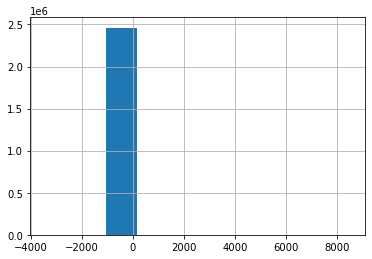

In [9]:
#  befor drop outlier
df["duration"].hist()

In [10]:
df = df[(df["duration"] >1) & (df["duration"] < 60)]

In [11]:
df["duration"].describe()

count    2.421030e+06
mean     1.267126e+01
std      8.994802e+00
min      1.016667e+00
25%      6.433333e+00
50%      1.023333e+01
75%      1.613333e+01
max      5.998333e+01
Name: duration, dtype: float64

<AxesSubplot:>

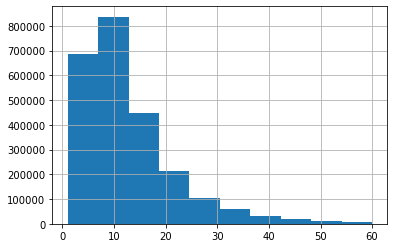

In [12]:
#  after drop outlier
df["duration"].hist()

In [13]:
print(f"Fraction of the records left after dropping the outliers {(len(df) / 2463930) * 100}")

Fraction of the records left after dropping the outliers 98.25887910776686


In [14]:
catFeat = ['PULocationID', 'DOLocationID']

df[catFeat] = df[catFeat].astype(object)

In [15]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [16]:
train_dicts = df[catFeat].to_dict(orient='records')

train_dicts

[{'PULocationID': 142, 'DOLocationID': 236},
 {'PULocationID': 236, 'DOLocationID': 42},
 {'PULocationID': 166, 'DOLocationID': 166},
 {'PULocationID': 114, 'DOLocationID': 68},
 {'PULocationID': 68, 'DOLocationID': 163},
 {'PULocationID': 138, 'DOLocationID': 161},
 {'PULocationID': 233, 'DOLocationID': 87},
 {'PULocationID': 238, 'DOLocationID': 152},
 {'PULocationID': 166, 'DOLocationID': 236},
 {'PULocationID': 236, 'DOLocationID': 141},
 {'PULocationID': 141, 'DOLocationID': 229},
 {'PULocationID': 114, 'DOLocationID': 90},
 {'PULocationID': 234, 'DOLocationID': 113},
 {'PULocationID': 246, 'DOLocationID': 79},
 {'PULocationID': 43, 'DOLocationID': 140},
 {'PULocationID': 239, 'DOLocationID': 151},
 {'PULocationID': 148, 'DOLocationID': 141},
 {'PULocationID': 237, 'DOLocationID': 107},
 {'PULocationID': 7, 'DOLocationID': 7},
 {'PULocationID': 107, 'DOLocationID': 263},
 {'PULocationID': 263, 'DOLocationID': 107},
 {'PULocationID': 161, 'DOLocationID': 161},
 {'PULocationID': 161

In [17]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

X_train

<2421030x2 sparse matrix of type '<class 'numpy.float64'>'
	with 4842060 stored elements in Compressed Sparse Row format>

In [18]:
dv.get_feature_names()

2023-05-23 08:10:39,153 [13452] WARNING  py.warnings:109: [JupyterRequire] C:\Users\moham\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)



['DOLocationID', 'PULocationID']

In [19]:
y_train = df["duration"].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

8.915721048047896

In [20]:
Residuals = y_train - y_pred
Residuals = pd.Series(Residuals)
Residuals

0           5.796529
1          -5.040536
2          -3.674914
3          -4.418445
4          23.777450
             ...    
2421025    -7.459077
2421026    -3.790158
2421027    -1.212221
2421028    -0.814568
2421029    14.767740
Length: 2421030, dtype: float64

<AxesSubplot:>

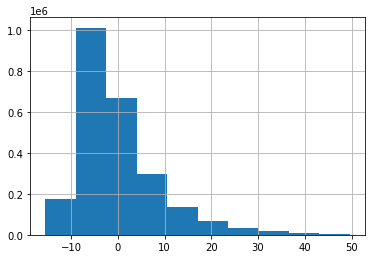

In [21]:
Residuals.hist()

In [22]:
def wrangle(filepath):
    df = pd.read_parquet(filepath)
    
    # extracte a duration column
    df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
    
    # convert a duration col to minutes 
    df["duration"] = df["duration"].apply(lambda x : x.total_seconds() / (60))
    
    # drop outlier
    df = df[(df["duration"] >1) & (df["duration"] < 60)]
    
    # select features 
    catFeat = ['PULocationID', 'DOLocationID']
    df[catFeat] = df[catFeat].astype(object)
    
    
    return df[catFeat] , df["duration"]

In [23]:
X_val, y_val = wrangle("data/yellow_tripdata_2022-02.parquet")
display(len(X_val))
print("=" * 40)
display(len(y_val))

2917760

2917760

In [24]:
val_dic = X_val.to_dict(orient = "records")
# val_dic

In [25]:
X_val = dv.transform(val_dic)
y_val_pred = lr.predict(X_val)

mean_squared_error(y_val, y_val_pred, squared=False)

9.63463783280025

In [26]:
lassoRig= Lasso(0.01)
lassoRig.fit(X_train, y_train)

y_pred = lassoRig.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

8.915721050304006

In [27]:
y_val_pred = lassoRig.predict(X_val)

mean_squared_error(y_val, y_val_pred, squared=False)

9.634637253853006